In [1]:
import numpy as np
from pandas import read_csv, DataFrame, concat

import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
from matplotlib.cm import rainbow
from matplotlib.colors import rgb2hex

from scipy.sparse import csc_matrix
from scipy.optimize import curve_fit
from scipy.stats import median_abs_deviation

from time import time
from sys import path as syspath
from sys import argv
import os

from multiprocessing import Pool,get_context
from functools import partial
import pickle

t00 = time()

try:
    rc('text', usetex = True)
except:
    pass
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['hatch.linewidth'] = 2.0 

plt.rcParams.update({
    "font.size":15,
    "figure.facecolor":  "white",  
    "axes.facecolor":    "white", 
    "savefig.facecolor": "white", 
})

try:
    get_ipython().__class__.__name__
    injupyternotebook = True

except:
    injupyternotebook = False


In [2]:
if not injupyternotebook:
    #star name
    star = argv[1]

    output_intermediate_results = False
else:
    star = "Sun"
    #star = "teststar"
    indic = "1"
    
    from IPython import display
    from IPython.core.display import display, HTML
    from bokeh.io import output_file
    from bokeh.plotting import Figure, output_notebook, show, save, ColumnDataSource

    display(HTML("<style>.container { width:90% !important; }</style>"))
    output_notebook()
    
    output_intermediate_results = True

Loading BokehJS ...

In [3]:
stardir = './stars/'+star+'/'

inf_name = stardir + 'input.py'
exec(open(inf_name).read())

In [4]:
syspath.insert(0, "./helper_functions/")

from classes import stellar_parameters,analyse,extract_rv_from_common_profiles,Gaussian,runLSD_inv,prep_spec3,RVerror

### Set parameters for computation (velcity grid width etc.)


In [5]:
if injupyternotebook:
    paramnr = 0 
    #results so far

else:
    paramnr = int(argv[2])
    #results so far
    resfile = f"{resdir}results_{star}_{indic}.csv"
    results = read_csv(resfile)

print(paramnr)


#load parameter combination
prms = read_csv(stardir+'params.csv')

maxdepthparam= prms["maxdepthparam"][paramnr]
mindepthparam = prms["mindepthparam"][paramnr]
telluric_cut = prms["telluric_cut"][paramnr]
velgridwidth = prms["velgridwidth"][paramnr]
modelspecdeviationcut = prms["modelspecdeviationcut"][paramnr]
max_nr_of_specs = prms["max_nr_of_specs"][paramnr]
exclwidelinesparam = prms["exclwidelinesparam"][paramnr]

rassoption = prms["rassoption"][paramnr]
erroption = prms["erroption"][paramnr]
telloption = prms["telloption"][paramnr]

#here we save the results of this parameter combination
newres = DataFrame()

#copy entries of parameter file
for key in prms.keys():
    newres[key] = [prms[key][paramnr]]

0


### Information about spectra

In [6]:
info_file = read_csv(dirdir+"Info.csv")

#set system RV. i.e. RV that is used to convert absorption line wavelengths from rest frame to stellar frame
systemrv = (info_file["rv_ccf"][0])

### Load data from VALD3


In [7]:
valddir = "./VALD_files/"
sp = stellar_parameters(star,valddir,dirdir,pipname,c)
sp.VALD_data()

loaded ./VALD_files/Sun.txt


### Load data from 1_preprocess notebook


In [8]:
an = analyse(c,sp.VALDlambdas,sp.VALDdepths)

In [9]:
with open(dirdir+"data_dict.pkl","rb") as f:
    prov = pickle.load(f)
    an.alldata = {}
    if rassoption==1:
        an.alldata["spectrum"] = prov["spectrum_overlap_corrected"]
        an.alldata["err"] = prov["err_overlap_corrected"]
        an.alldata["err_envelope"] = prov["err_envelope_overlap_corrected"]
        an.alldata["wavelengths"] = prov["wavelengths"]
    del prov

In [10]:
# save these for later.

iis = list(an.alldata["spectrum"].keys())

#index numbers of spectra
an.iis = iis

#see input.py
an.excllower = excllower
an.exclupper = exclupper
an.telluric_cut = telluric_cut
an.modelspecdeviationcut = modelspecdeviationcut
an.mindepthparam = mindepthparam
an.maxdepthparam = maxdepthparam
an.exclwidelinesparam = exclwidelinesparam
an.telloption = telloption

nr_of_orders,nr_of_pixels = an.alldata["spectrum"][0].shape

#shift fluxes to between -1 and 0 for lsd procedure
for key in iis:
    an.alldata["spectrum"][key] = an.alldata["spectrum"][key]-1
    
    
    
an.tapas_tellurics = {}
an.resdir = resdir

In [11]:
an.barycentric_to_stellar_restframe = {}
an.observatory_to_barycentric_restframe = {}
an.observatory_to_stellar_restframe = {}

for ii in iis:
    an.barycentric_to_stellar_restframe[ii] = 1.0 / (1.0 + systemrv / c)
    an.observatory_to_barycentric_restframe[ii] = 1.0 + info_file["berv"][0] / c
    an.observatory_to_stellar_restframe[ii] = (
        an.observatory_to_barycentric_restframe[ii]
        * an.barycentric_to_stellar_restframe[ii]
    )

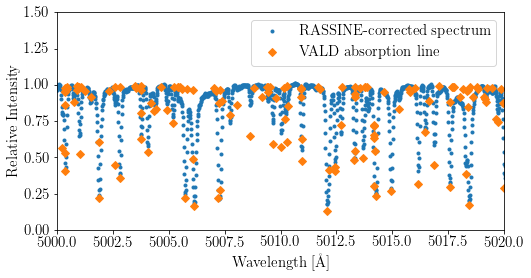

In [12]:
if output_intermediate_results:
    sp.inspect_data(0,an.alldata["spectrum"][0]+1,an.alldata["wavelengths"][0],5000,20)

### Get tapas telluric information

In [13]:
compute_tellurics = True

if os.path.exists("./tellurics/tellurics"+star+".pkl"):
    with open("./tellurics/tellurics"+star+".pkl","rb") as f:
        an.tapas_tellurics = pickle.load(f)
        
    if len(iis) == len(an.tapas_tellurics.keys()):
        compute_tellurics = False
        if output_intermediate_results:
            print(f"loaded tellurics from ./tellurics/tellurics"+star+".pkl")
    else:
        compute_tellurics = True
        

if compute_tellurics:
    print("produce tellurics")
    
    transmittance_file = None
    an.get_tapas_transmittance(pipname , transmittance_file, info_file)
    print("save tellurics in ","./tellurics/tellurics"+star+".pkl")
    with open("./tellurics/tellurics"+star+".pkl","wb") as f:
        pickle.dump(an.tapas_tellurics,f)

loaded tellurics from ./tellurics/telluricsSun.pkl


### Set preliminary velocity grid


In [14]:
#set velocity grid

#roughly centre velocity grid around the rv of the star of the first measurement. add +- dvel km/s
dvel = 20
vel_inital = np.arange(systemrv-dvel, systemrv+dvel, vStep)

#set upper limit to number of absorption lines of depth min_depth_required within a region (other regions excluded)
an.alldata["vel_inital"] = vel_inital

### FIRST RUN OF LSD (TO GET FWHM OF SPECTRA, FIRST COMMON PROFILE, AND TO CHECK DEVIATION OF SPECTRA FROM CONVOLUTION MODEL))

In [15]:
#choose test spectrum for the first LSD run
test_ii = 0

an.test_ii = test_ii

#get fluxes, wavelengths, and weights for first spectrum
an.prep_spec(iis[test_ii],an.alldata,erroption)

#choose echelle orders to run code on (all here)
testorders = np.arange(nr_of_orders)

#get rough common profile (equal weight for each order). this is only used to get an idea about the common profile shape.
zlast = np.zeros((len(vel_inital))) 
model_h = np.zeros((nr_of_orders,nr_of_pixels))
count = 0

for order in testorders:
    output = an.worker(order,vel_inital)
    if not np.isnan(output[0]).any():
        model_h[order,:] = output[1]
        zlast += output[0]
        count +=1
zlast/=count

an.model_h = model_h
an.div = np.abs(model_h - an.spectrum)

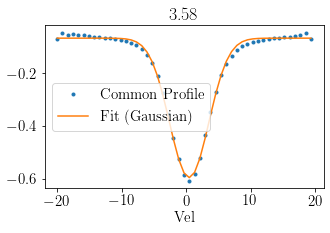

In [16]:
#first common profile

#fit gaussian to common profile and extraxt hwhm
popt, pcov = curve_fit(Gaussian, vel_inital, zlast, [-1, systemrv, 3, 0])
fit = Gaussian(vel_inital,*popt)  

vel_hwhm = np.abs(popt[2])*np.sqrt(np.log(2.)*2.)

if output_intermediate_results:
    plt.figure(figsize=(5,3))
    plt.plot(vel_inital,zlast,".",label="Common Profile")
    plt.plot(vel_inital,fit,label="Fit (Gaussian)")
    
    plt.xlabel("Vel")
    plt.title(np.round(vel_hwhm,2))
    plt.legend()

#estimate typical half-width of an absorption line as 5 times the hwhm
#will be multiplied by wvl when used

an.alldata["initial_v_halfwidth"]=vel_hwhm

### Set velocity grid

In [17]:
#new velocity grid based on first run.

dvel = np.round(vel_hwhm)*velgridwidth
vel = np.arange(systemrv-dvel, systemrv+dvel, vStep)

#set upper limit to number of absorption lines of depth min_depth_required within a region (other regions excluded)
an.alldata["vel"] = vel

#how much should we exclude near data points with high model-spectrum deviation?
an.alldata["absline_halfwidth_include"] = (vel.max()-vel.min()+1.)/2./c

### EXCLUDE SPECTRAL REGIONS WITH HIGH MODEL-SPECTRUM DEVIATION

In [18]:
an.get_wide_lines()
an.get_q_map(info_file)
#get telluric map.
an.get_t_map()

In [19]:
if output_intermediate_results and False:
    an.show_map()

### RUN LSD ON ALL SPECTRA WITH QUALITY/TELLURIC MAP

In [20]:
def worker3(order,weights,spectrum,wavelengths,vlambda,vdepth,vel):
    """
    For given order: perform LSD and extract the common profile, common profile uncertainties. Compute convolution model 
    Parameters
    ----------
    order : int
        First array: periods [d]
    weights : array orders x pixels
        Weights of the individual fluxes
    spectrum : array orders x pixels
        Fluxes
    wavelengths : array orders x pixels
        Wavelength corresponding to the fluxes
    vlambda : array
        Central wavelength of absorption lines (VALD3)
    vdepth : array
        Depth of absorption lines (VALD3)
    vel : array
        Velocity grid to run LSD on (velocity grid for common profile)
    
    Output:
    ----------
    Z : array
        common profile
    Zerr : array
        uncertainty estimates of common profile
    M.dot(Z) : array
        convolution model
    selection : array
        indices of included pixels
    """    

    #Get data of given order

    #Only include data with weight > 0
    selection = np.where(weights[order,:]>0)[0]
    spectrum_o = spectrum[order,:][selection]

    #Don't run if only 2% of order included. Bad order.
    if len(selection)<0.02*len(spectrum_o):
        return 0
    
    wavelengths_o = wavelengths[order,:][selection]
    weights_o = weights[order,:][selection]           

    #CREATE CONVOLUTION MATRIX
    #-----------------------------------------------------
    value, row, column = an.cvmt(wavelengths_o, vel, vlambda,vdepth)
    
    M = csc_matrix((value,(row,column)), shape=(len(wavelengths_o), len(vel)))
    #-----------------------------------------------------

    Z,Zerr = runLSD_inv(value, row, column, len(wavelengths_o), len(vel), weights_o, spectrum_o) 
    
    return Z,Zerr,M.dot(Z),selection


In [21]:
#multiprocessing
num_processors = 4

#on which orders to run
testorders = np.arange(nr_of_orders)

#save results here
LSD_results = {}

vel = an.alldata["vel"]

In [22]:
t_start = time()

for ii in iis:
    if output_intermediate_results:
        print(ii,np.round(time()-t_start,2))
    
    #get weights, spectrum, wavelengths after excluding some data according to parameters.
    weights,spectrum,wavelengths = prep_spec3(an.alldata,ii,an.tapas_tellurics,erroption=erroption,usetapas=usetapas)

    #empty containers
    LSD_results[ii] = {}
    common_profile_all_orders = np.zeros((np.shape(wavelengths)[0],len(vel)))
    common_profile_all_orders_err = np.zeros((np.shape(wavelengths)[0],len(vel)))
    MZ = np.zeros((np.shape(wavelengths)[0],len(an.alldata["spectrum"][ii][20,:])))
    incl_map = np.zeros((np.shape(MZ)))

    #partial function for multiprocessing
    worker_partial3 = partial(worker3,
                              weights=weights,
                              spectrum=spectrum,
                              wavelengths=wavelengths,
                              vlambda=sp.VALDlambdas,
                              vdepth=sp.VALDdepths,
                              vel=vel)

    #initialise multiprocessing
    with get_context("fork").Pool(processes = num_processors) as p:
        output = p.map(worker_partial3,[order for order in testorders])

    #save output into containers
    for order in testorders:
        if output[order]!=0:
            common_profile_all_orders[order,:] = output[order][0]
            common_profile_all_orders_err[order,:] = output[order][1]
            selection = output[order][3]
            MZ[order,:][selection] = output[order][2]
            incl_map[order,:][selection] = np.ones((len(selection)))

    #save results in dict
    LSD_results[ii]["common_profile"] = common_profile_all_orders  
    LSD_results[ii]["common_profile_err"] = common_profile_all_orders_err
    LSD_results[ii]["LSD_spectrum_model"] = MZ   # LSD_spectrum
    LSD_results[ii]["incl_map"] = incl_map
    
if injupyternotebook:
    print("Computation time:", np.round((time()-t_start)/60.,1),"minutes")

0 0.0
1 0.47
2 0.9
3 1.45
4 1.78
Computation time: 0.0 minutes


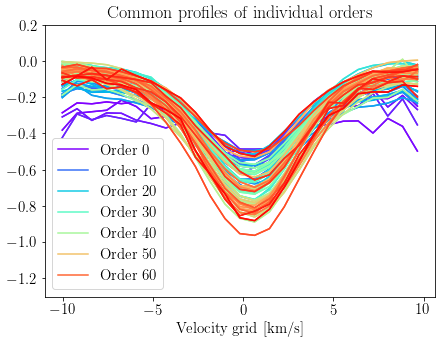

In [23]:
# inspect the individual common profiles
if output_intermediate_results:

    plt.figure(figsize=(7,5))
    
    for order in range(len(LSD_results[test_ii]["common_profile"])):

        color = rgb2hex(rainbow(order/nr_of_orders))

        plt.plot(vel,LSD_results[ii]["common_profile"][order],color=color)
        
        if order//10 == order/10:
            plt.plot(vel,LSD_results[ii]["common_profile"][order],color=color,label="Order "+str(order))
        else:
            plt.plot(vel,LSD_results[ii]["common_profile"][order],color=color)

    plt.legend()
    plt.ylim(-1.3,0.2)
    
    plt.xlabel("Velocity grid [km/s]")
    plt.title("Common profiles of individual orders")
    
    plt.savefig(an.resdir+f"Common_profiles.pdf")

In [24]:
#define weight matrix to compute order weights (to combine common profiles to master common profile)

wmat = np.ones((len(iis),nr_of_orders))

for count1,ii in enumerate(iis):
    if erroption == 0:
        pre_weights = 1./(an.alldata["err"][ii]**2)
    if erroption ==1:
        pre_weights = 1./(an.alldata["err_envelope"][ii]**2)
    if erroption ==2:
        err = np.transpose(np.tile(np.median(an.alldata["err"][ii],axis=1),(np.shape(an.alldata["err"][0])[1],1)))
        pre_weights = 1./(err**2)

    pre_weights[LSD_results[ii]["incl_map"]==0]=0

    for count,order in enumerate(testorders):
        wmat[count1,order] = np.nanmean(pre_weights[order,:])

an.alldata["order_weight"] = np.mean(wmat,axis=0)

In [25]:
#check excluding outer parts of common profile. see paper.
testsigma = np.arange(1.0,5,step=0.25)*an.alldata["initial_v_halfwidth"]


std_dep_on_sigma = np.zeros((len(testsigma)))
an.alldata["fitfunction"] = "Gaussian"
order_choice = np.arange(nr_of_orders)

for count,sigma in enumerate(testsigma):
    an.alldata["sigmafit"] = sigma

    lsd_rv_orig, Zs,Z,Zerrs = extract_rv_from_common_profiles(LSD_results,an.alldata,iis,order_choice,weight_orders=weight_schemes[0],use_uncertainties=True)
    
    lsd_norm_t = lsd_rv_orig - np.median(lsd_rv_orig)
    no_outliers = np.where(np.abs(lsd_norm_t-np.median(lsd_norm_t))<delta_rv_outlier)[0]

    lsd_norm_t = lsd_norm_t[no_outliers]
    std_dep_on_sigma[count] = np.std(lsd_norm_t)

an.alldata["sigmafit"] = testsigma[np.argmin(std_dep_on_sigma)]
an.alldata["sigmafit_used"] = np.copy(testsigma[np.argmin(std_dep_on_sigma)])



In [26]:
if len(iis)!=len(no_outliers):
    print(f"Removed {len(iis)-len(no_outliers)} out of {len(iis)} spectra due to |RV-med(RV)| >= delta_rv_outlier (= {delta_rv_outlier} m/s)")

In [27]:
#compare LSD results to DRS CCF method
drs_rv_orig = info_file["rv_ccf"].values*1000.
t = info_file["mjd"].values


for weight_scheme in weight_schemes:
    for use_uncertainties in [True]:
        #only second one is used for plots later on

        #"flux weight2b": weight of order o same for all spectra (=weight of order o in first spectrum)
        #"flux weight2c": weight of order o varies (depending on weight of fluxes in order o in spectrum ii)

        #choose an LSD container

        #this extracts the RV information
        lsd_rv_orig, Zs,Z,Zerrs = extract_rv_from_common_profiles(LSD_results,an.alldata,iis,order_choice,weight_orders=weight_scheme,use_uncertainties=use_uncertainties)

        if pipname == "DRS_3.7":
            #drift correction
            lsd_rv_orig -= info_file["drift"].values
            #drs_rv_orig -= info_file["drift"].values

        # subtract median radial velocity to analyse rv change   
        drs_norm = drs_rv_orig - np.median(drs_rv_orig)
        lsd_norm = lsd_rv_orig - np.median(lsd_rv_orig)

        #------------------------
        #remove outliers
        no_outliers = np.where(np.abs(drs_norm-np.median(drs_norm))<200)[0]

        if len(no_outliers)<len(drs_norm):
            print(f"Removed {len(drs_norm)-len(no_outliers)} outliers.")

        drs_norm = drs_norm[no_outliers]
        lsd_norm = lsd_norm[no_outliers]

        t = t[no_outliers]

        #yerr = np.asarray(list(an.alldata["ccfrvs_err"].values()))[no_outliers]*1000.
        yerr = info_file["rv_ccf_error"].values[no_outliers]*1000.

        #------------------------


        difference = drs_norm -lsd_norm

        print("LSD RMS: ",np.std(lsd_norm).round(2),"m/s")


LSD RMS:  1.0 m/s


STD:	 LSD: 1.00 m/s 	 	 DRS: 2.41 m/s
MAD:	 LSD: 0.81 m/s 	 	 DRS: 2.76 m/s


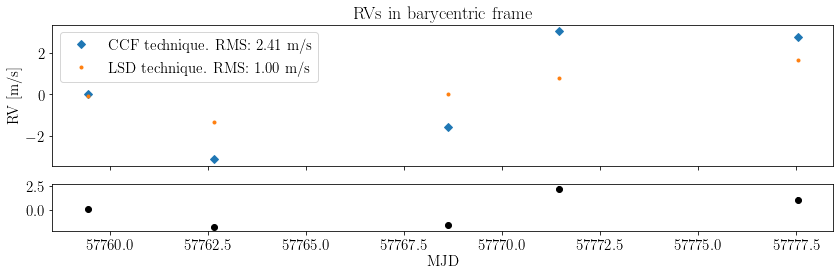

In [28]:
if output_intermediate_results:

    fig,ax = plt.subplots(2,1,figsize=(14,3.8),gridspec_kw={'height_ratios': [3, 1]},sharex=True)
    ax[0].set_title("RVs in barycentric frame")
    #ax[0].set_ylim(-10,20)

    ax[0].plot(t ,drs_norm,"D",label=f"CCF technique. RMS: {np.std(drs_norm):.2f} m/s")
    ax[0].plot(t ,lsd_norm,".",label=f"LSD technique. RMS: {np.std(lsd_norm):.2f} m/s")
    #ax[0].plot(t-2450000 ,lsd_norm_avg,".",label="LSD\_avg")


    ax[0].set_ylabel("RV [m/s]",fontsize=15)
    ax[0].legend(fontsize=15)
    ax[1].errorbar(t,difference,yerr=yerr, fmt='o',color="black")

    plt.xlabel(r"MJD",fontsize=15)

    print(f"STD:\t LSD: {np.std(lsd_norm):.2f} m/s \t \t DRS: {np.std(drs_norm):.2f} m/s")
    print(f"MAD:\t LSD: {median_abs_deviation(lsd_norm):.2f} m/s \t \t DRS: {median_abs_deviation(drs_norm):.2f} m/s")
    
    plt.savefig(an.resdir+f"RVs.pdf")
    

In [29]:
#save results
if not injupyternotebook:
    yerr_wls = np.zeros((len(lsd_norm)))
    for count,ii in enumerate(np.asarray(iis)[no_outliers]):
        rverrc = RVerror(vel, Zs[ii], Zerrs[ii])
        yerr_wls[count] = rverrc*1000.


    newres["LSD RV std"] = [np.std(lsd_norm).round(3)]
    newres["LSD RV MAD"] = [median_abs_deviation(lsd_norm).round(3)]
    newres["DRS RV std"] = [np.std(drs_norm).round(3)]
    newres["DRS RV MAD"] = [median_abs_deviation(drs_norm).round(3)]
    newres["sigmafit_used"] = [an.alldata["sigmafit_used"].round(3)]
    newres["comp time"] = [np.round(time()-t00,1)]
    
    nn = concat([results,newres])
    nn.to_csv(resfile,index=False)
    
    
    

    if os.path.exists(rvresfile):
        f = open(rvresfile,"rb")
        dth = pickle.load(f)
        dth[paramnr]= lsd_norm  
        f.close()
    else:
        f = open(rvresfile,"wb")
        dth = {}
        dth["mjd"] = t
        dth["rv_ccf"] = drs_norm
        dth["rv_ccf_err"] = yerr
        
        dth[paramnr]=lsd_norm
        
    f = open(rvresfile,"wb")
    pickle.dump(dth,f)
    f.close()
    
    if os.path.exists(rverrresfile):
        f = open(rverrresfile,"rb")
        dth = pickle.load(f)
        dth[paramnr] = yerr_wls  
        f.close()
    else:
        f = open(rverrresfile,"wb")
        dth = {}
        dth["mjd"] = t
        dth["rv_ccf"] = drs_norm
        dth["rv_ccf_err"] = yerr
        
        dth[paramnr] = yerr_wls
        
    f = open(rverrresfile,"wb")
    pickle.dump(dth,f)
    f.close()
    
    
    if os.path.exists(commonprofilefile):
        f = open(commonprofilefile,"rb")
        dth = pickle.load(f)
        dth[f"vel_{paramnr}"]= vel
        dth[f"Z_{paramnr}"]= Zs
        f.close()
    else:
        f = open(commonprofilefile,"wb")
        dth = {}
        dth["mjd"] = t
        dth[f"vel_{paramnr}"] = vel
        dth[f"Z_{paramnr}"] = Zs 
        
    f = open(commonprofilefile,"wb")
    pickle.dump(dth,f)
    f.close()